In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [2]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:

# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
  
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [5]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647) # for reproducibility
C  = torch.randn((vocab_size, n_embd),            generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size)**0.5) #* 0.2
b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),          generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))

parameters = [C, W1,b1, W2, b2 , bngain , bnbias]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

12297


In [6]:
W1[2].shape

torch.Size([200])

In [94]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
  
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear layer
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    
    #Batch Norm layer
    bnmean = hpreact.mean(0,keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)
    hpreact = bngain*(hpreact - bnmean)/bnstd + bnbias
    
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmean
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstd
        
        
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function
  
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 90000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr * p.grad

  # track stats
    if i % 10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())

TypeError: unsupported operand type(s) for *: 'float' and 'NoneType'

In [82]:
# calibrate the batch norm at the end of traning
with torch.no_grad():
    #pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hreact = embcat @ W1 + b1
    # measure the mean/std over the entire traning set
    bnmean = hpreact.mean(0,keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [83]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x,y = {
       'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte),
    }[split]
    emb = C[x] # (N, block_size, n_embd)
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact= embcat@ W1 + b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
   
    h = torch.tanh(hpreact) # (N, n_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0647971630096436
val 2.1040759086608887


(array([483., 235., 178., 137., 137., 130.,  86., 104., 104.,  90.,  90.,
         90., 112., 111., 100.,  90.,  97., 103., 122., 115., 122., 126.,
         85., 106., 103., 113., 130.,  99., 103., 112., 108.,  97.,  88.,
         89., 124.,  76.,  94.,  75.,  82.,  90.,  89., 112.,  99., 128.,
        121., 114., 145., 152., 238., 466.]),
 array([-9.99988496e-01, -9.59989692e-01, -9.19990888e-01, -8.79992083e-01,
        -8.39993279e-01, -7.99994475e-01, -7.59995670e-01, -7.19996866e-01,
        -6.79998062e-01, -6.39999257e-01, -6.00000453e-01, -5.60001649e-01,
        -5.20002844e-01, -4.80004040e-01, -4.40005236e-01, -4.00006431e-01,
        -3.60007627e-01, -3.20008823e-01, -2.80010018e-01, -2.40011214e-01,
        -2.00012410e-01, -1.60013605e-01, -1.20014801e-01, -8.00159967e-02,
        -4.00171924e-02, -1.83880329e-05,  3.99804163e-02,  7.99792206e-02,
         1.19978025e-01,  1.59976829e-01,  1.99975634e-01,  2.39974438e-01,
         2.79973242e-01,  3.19972047e-01,  3.59970

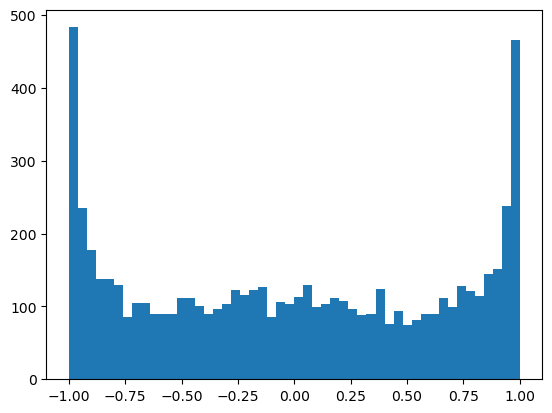

In [84]:
plt.hist(h.view(-1).tolist(),50)

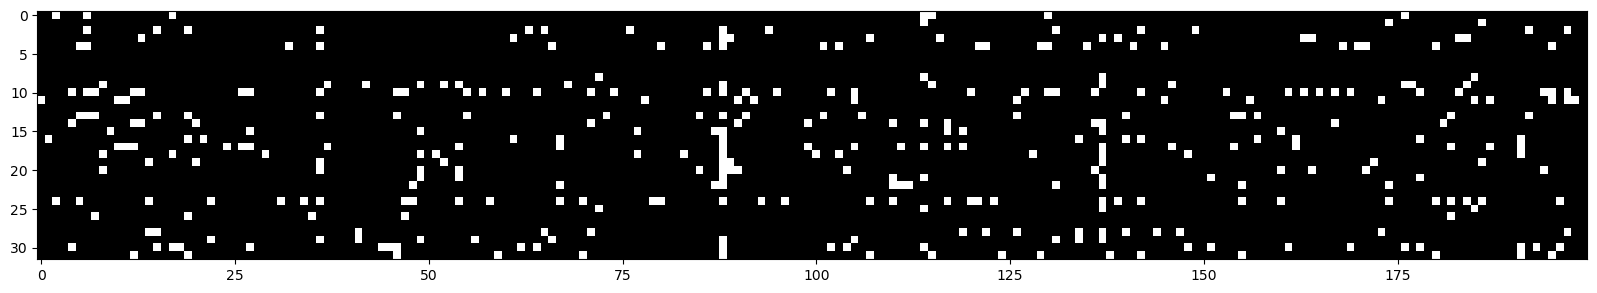

In [85]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99 , cmap="gray", interpolation="nearest")

tensor(-0.0022) tensor(1.0029)
tensor(0.0004) tensor(0.9902)


(array([4.43997698e-05, 0.00000000e+00, 6.65996548e-05, 1.33199310e-04,
        1.33199310e-04, 2.44198734e-04, 3.32998274e-04, 7.54796087e-04,
        1.30979321e-03, 1.79819068e-03, 3.46318205e-03, 5.15037330e-03,
        8.30275696e-03, 1.50071222e-02, 2.39980756e-02, 3.84058009e-02,
        5.67429059e-02, 8.13625782e-02, 1.18347587e-01, 1.63790751e-01,
        2.19068464e-01, 2.84424926e-01, 3.46296005e-01, 3.95868348e-01,
        4.29212575e-01, 4.30810967e-01, 4.04570703e-01, 3.47716798e-01,
        2.89153501e-01, 2.28592215e-01, 1.71116713e-01, 1.21100372e-01,
        9.10417281e-02, 5.77863004e-02, 3.91605970e-02, 2.55742674e-02,
        1.53623204e-02, 9.41275121e-03, 5.74977019e-03, 3.44098216e-03,
        2.48638711e-03, 1.39859275e-03, 5.54997123e-04, 3.32998274e-04,
        4.43997698e-05, 1.55399194e-04, 6.65996548e-05, 0.00000000e+00,
        4.43997698e-05, 4.43997698e-05]),
 array([-5.64393377, -5.41870738, -5.19348099, -4.96825459, -4.7430282 ,
        -4.51780181, 

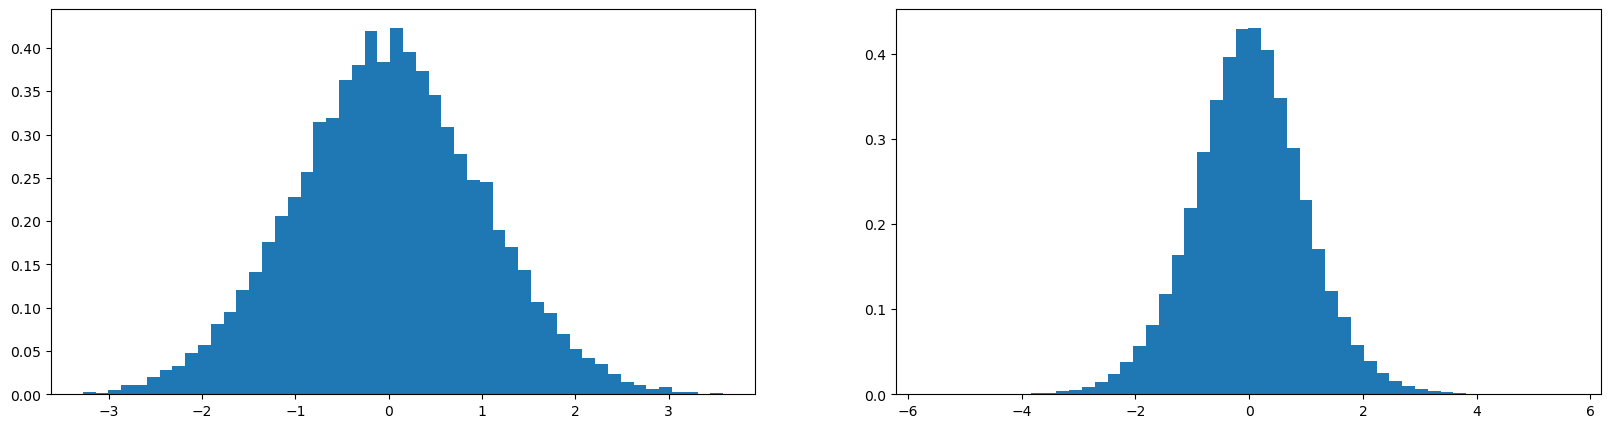

In [86]:
x = torch.randn(1000,10)
w= torch.randn(10,200)/10**0.5
y = x@w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50 , density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50 , density=True)

In [87]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g)/fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self,x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backpropp)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.zeros(dim)
    
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0 , keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True, unbiased=True) # batch variance
        else:
            xmean= self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
            return self.out
        
    def parameters(self):
            return [self.gamma, self.beta]
        
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
n_embd = 10 #the dimensionality of the charactor embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647) # for reproducibility

C = torch.randn((vocab_size,n_embd), generator=g)
layers = [
    Linear(n_embd * block_size,n_hidden,bias=False),BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden , n_hidden,bias=False), BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden , n_hidden,bias=False), BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden , n_hidden,bias=False), BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden , n_hidden,bias=False), BatchNorm1d(n_hidden),Tanh(),
    Linear(         n_hidden , vocab_size,bias=False),BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    #all other layers : apply gain
    for layer in layers[:-1]:
        if isinstance (layer, Linear):
            layer.weight*=1.0 #5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True
        

47024


In [88]:
max_steps = 200000
batch_size = 32
lossi = []
ud = []
for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0],(batch_size,),generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y
    
    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x,Yb) # loss function
    
    #backward pass
    for layer in layers:
        layer.out.retain_grad() # After_Dubug : would take out retain_graph
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 150000 else 0.01 # step learning rate decay
    for p in parameters:
        p.data += -lr*p.grad
    
    # track stats
    if i%10000 == 0: # print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([((lr*p.grad).std() / p.data.std()).log10().item() for p in parameters])
    if i >= 1000:
        break

      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.78%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.56%
layer 8 (      Tanh): mean -0.00, std 0.65, saturated: 2.25%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.69%
layer 14 (      Tanh): mean +0.00, std 0.65, saturated: 1.88%


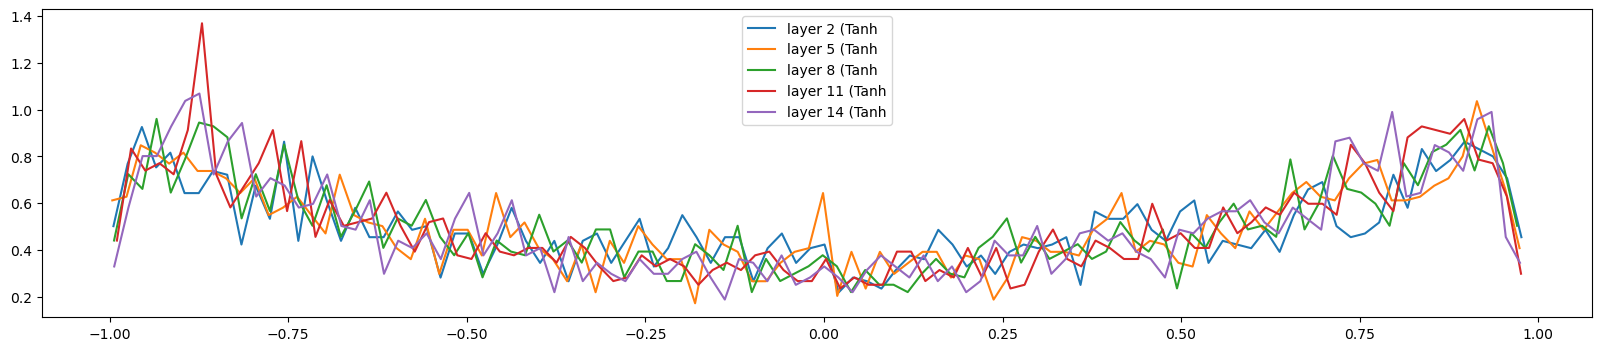

In [89]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print('layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%' % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
# plt.title('activation distribution'

layer 2 (      Tanh): mean +0.000000, std 2.640703e-03
layer 5 (      Tanh): mean -0.000000, std 2.245584e-03
layer 8 (      Tanh): mean -0.000000, std 2.045742e-03
layer 11 (      Tanh): mean +0.000000, std 1.983134e-03
layer 14 (      Tanh): mean -0.000000, std 1.952382e-03


Text(0.5, 1.0, 'gradient distribution')

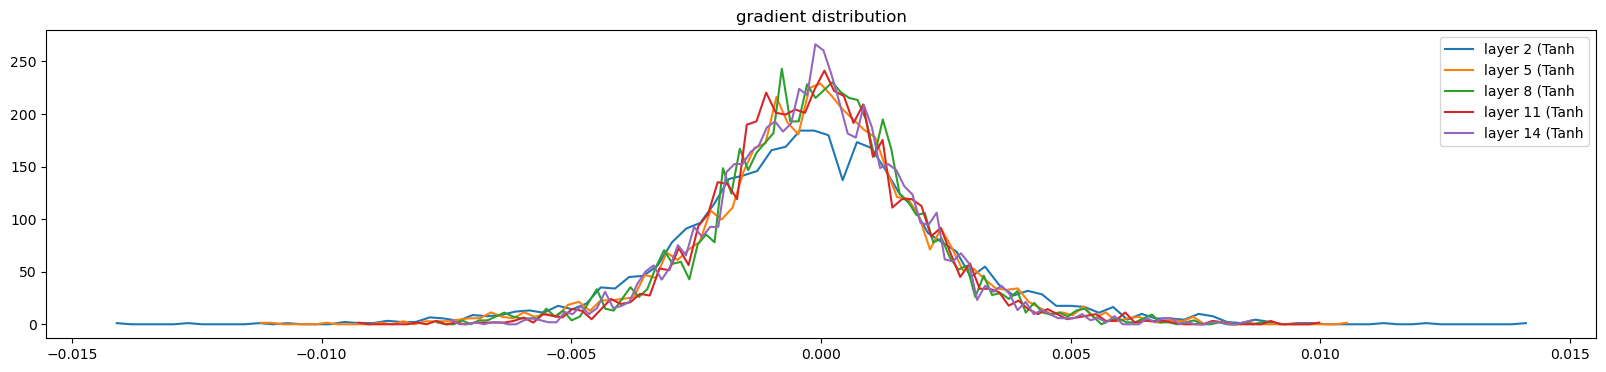

In [90]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude the output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print('layer %d (%10s): mean %+f, std %e' % (i, layer.__class__.__name__, t.mean(), t.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__}')
plt.legend(legends);
plt.title('gradient distribution')

weight   (27, 10) | mean -0.000000 | std 8.020533e-03 | grad:data ratio 8.012629e-03
weight  (30, 100) | mean +0.000246 | std 9.241072e-03 | grad:data ratio 4.881088e-02
weight (100, 100) | mean +0.000113 | std 7.132879e-03 | grad:data ratio 6.964619e-02
weight (100, 100) | mean -0.000086 | std 6.234301e-03 | grad:data ratio 6.073737e-02
weight (100, 100) | mean +0.000052 | std 5.742184e-03 | grad:data ratio 5.631479e-02
weight (100, 100) | mean +0.000032 | std 5.672205e-03 | grad:data ratio 5.570126e-02
weight  (100, 27) | mean -0.000082 | std 1.209415e-02 | grad:data ratio 1.160105e-01


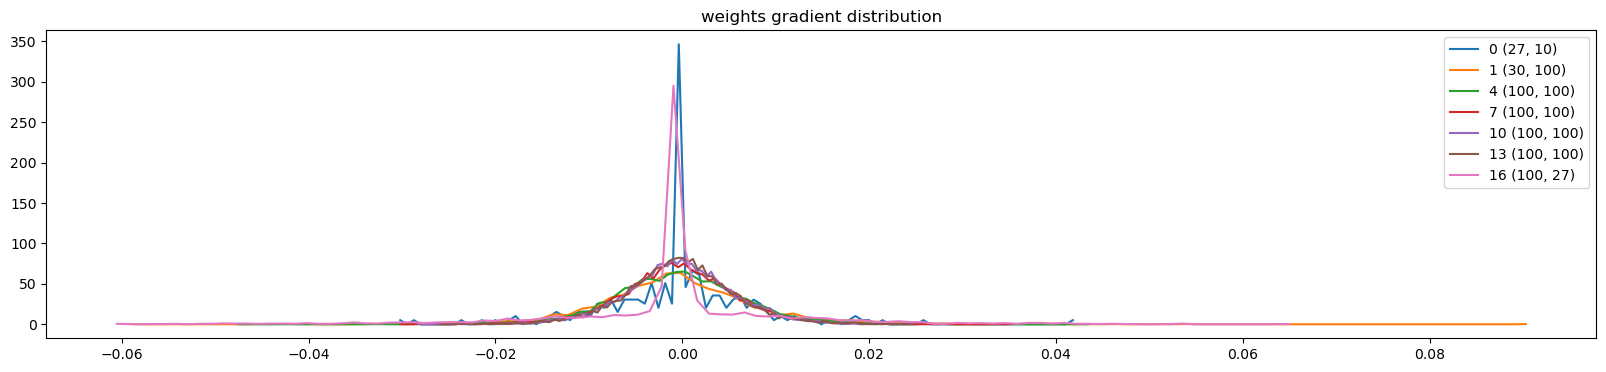

In [91]:
# visualize histograms
plt.figure(figsize=(20, 4)) # width and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print('weight %10s | mean %+f | std %e | grad:data ratio %e' % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution');

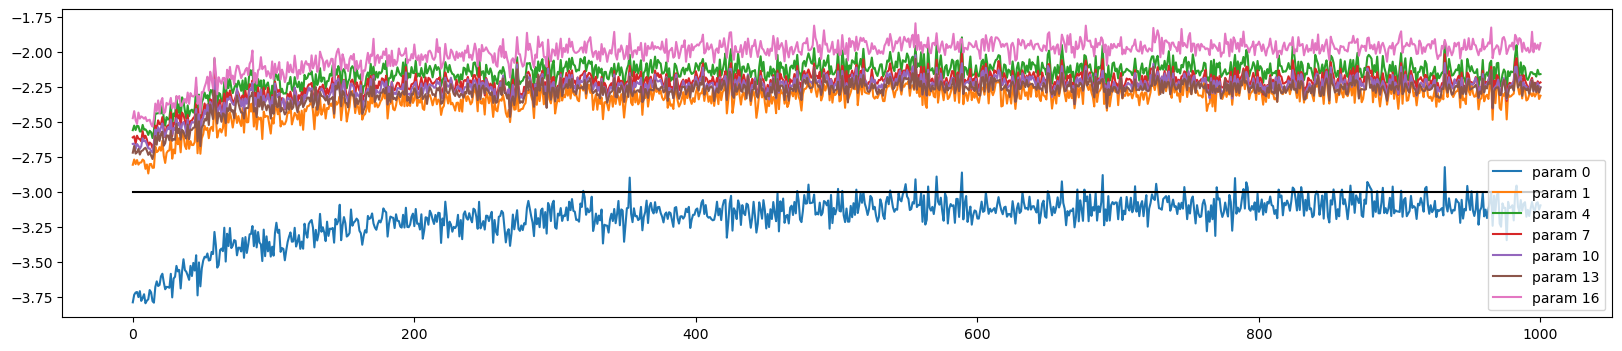

In [92]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends);

In [96]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1,-1)@ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator = g).item()
        context = context[1:]+ [ix]
        out.append(ix)
        # if we sample the special '.' token break
        if ix == 0:
            break
    print(''.join(itos[i] for i in out)) # decode and print the generated word

bruaislyarluzelwrdyn.
klatrisrethjdriennshmreddelishbngnjedrekessusttnarlellbrohmurain.
shdunrgshb.
jess.
jatrwnllipxnlexbriuo.
brude.
jamyle.
qhgylleshbstlyss.
hzz.
sasylvethn.
brull.
brrij.
rivavgevoecknfrextnshb.
bruhmbpti.
jakegryxvehmretnbis.
sill.
westdwnllanidttsfnntnnshbill.
britnn.
dvblairis.
brulrkethrriylxabutun.
